In [1]:
import sys
sys.path.insert(0, '../src')

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch

from concepts import concept_instances
from sk_probing import train_binary, train_non_binary
from utils import load_game_data, load_q_network_device

In [3]:
max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5
layers = [0,1,2,3,4,5,6,7,8]

In [4]:
game_data = load_game_data()

In [6]:
q_network, device = load_q_network_device()
scores = {}
for concept in concept_instances.values():
    if concept.name == 'random (b)':
        continue
    concept.prepare_data(game_data, max_size=max_data_size)
    _, train_acts_dict = q_network(torch.tensor(concept.train_obs).to(device), return_acts=True)
    _, test_acts_dict = q_network(torch.tensor(concept.test_obs).to(device), return_acts=True)
    train_values = concept.train_values
    test_values = concept.test_values

    concept_scores = []
    for layer in layers:
        train_acts = train_acts_dict[str(layer)].cpu().detach().numpy()
        test_acts = test_acts_dict[str(layer)].cpu().detach().numpy()
        train_acts = train_acts.reshape(len(train_acts), -1)
        test_acts = test_acts.reshape(len(test_acts), -1)

        if concept.binary:
            reg, score = train_binary(train_acts, train_values, test_acts, test_values, max_iter, k_fold, num_reg)
        else:
            reg, score = train_non_binary(train_acts, train_values, test_acts, test_values, max_iter, k_fold, num_reg)
        concept_scores.append(max(0, round(score,3)))
    print(concept.name, concept_scores)
    scores[concept.name] = concept_scores

ball y [0.506, 0.53, 0.728, 0.78, 0.782, 0.784, 0.784, 0.788, 0.789]
ball x [0.636, 0.628, 0.836, 0.869, 0.892, 0.885, 0.885, 0.817, 0.617]
ball low (b) [0.79, 0.89, 0.96, 0.97, 0.99, 0.99, 0.99, 0.96, 0.89]
ball collision (b) [0.58, 0.62, 0.66, 0.7, 0.67, 0.69, 0.69, 0.63, 0.56]
ball going right (b) [0.27, 0.24, 0.3, 0.52, 0.59, 0.66, 0.66, 0.59, 0.39]
ball going left (b) [0.25, 0.27, 0.24, 0.49, 0.62, 0.63, 0.63, 0.55, 0.37]
ball going up (b) [0.32, 0.33, 0.3, 0.72, 0.78, 0.83, 0.83, 0.84, 0.76]
ball going down (b) [0.36, 0.38, 0.48, 0.66, 0.81, 0.81, 0.81, 0.82, 0.78]
ball speed [0.254, 0.201, 0.263, 0.272, 0.311, 0.32, 0.32, 0.28, 0.205]
paddle x [0.988, 0.991, 0.987, 0.985, 0.979, 0.956, 0.956, 0.926, 0.757]
ball left for paddle (b) [0.51, 0.56, 0.59, 0.74, 0.63, 0.74, 0.74, 0.76, 0.61]
ball right for paddle (b) [0.56, 0.69, 0.66, 0.74, 0.63, 0.73, 0.73, 0.67, 0.48]
ball above paddle (b) [0.33, 0.4, 0.5, 0.53, 0.58, 0.55, 0.55, 0.61, 0.49]
ball paddle distance [0.634, 0.631, 0.702

/tmp/ipykernel_558/2464926879.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(scores.keys()))


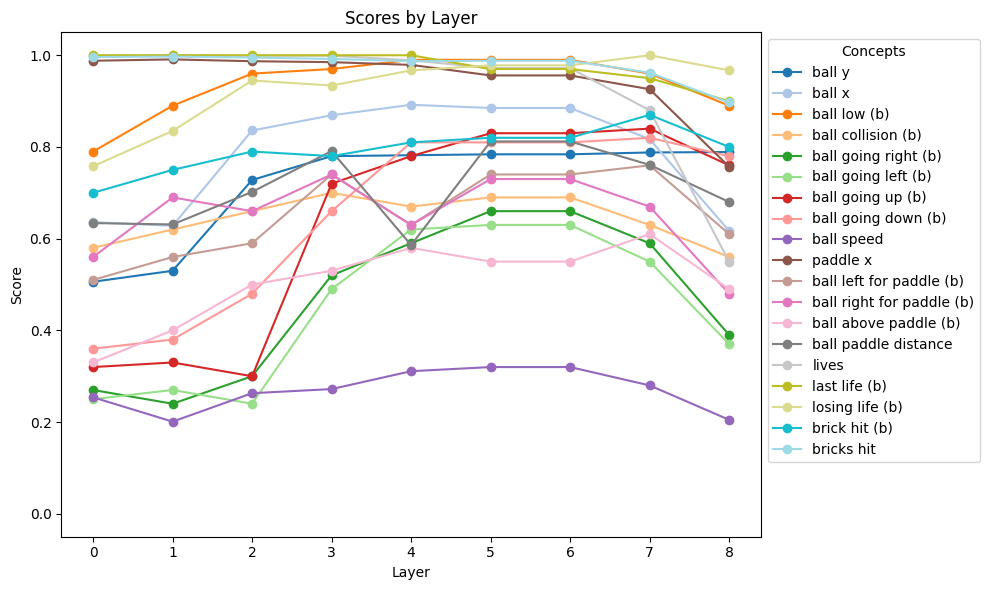

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
cmap = cm.get_cmap('tab20', len(scores.keys()))

# Iterate through concepts and plot each with a unique color from the colormap
for i, (concept, concept_scores) in enumerate(scores.items()):
    color = cmap(i)
    ax.plot(layers, concept_scores, marker='o', label=concept, color=color)

ax.set_xlabel('Layer')
ax.set_xticks(layers)
ax.set_ylabel('Score')
ax.set_ylim([-0.05, 1.05])
ax.set_title('Scores by Layer')

# Placing the legend outside the plot
ax.legend(title="Concepts", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('../figures/concept scores/concept_scores.png')
plt.show()

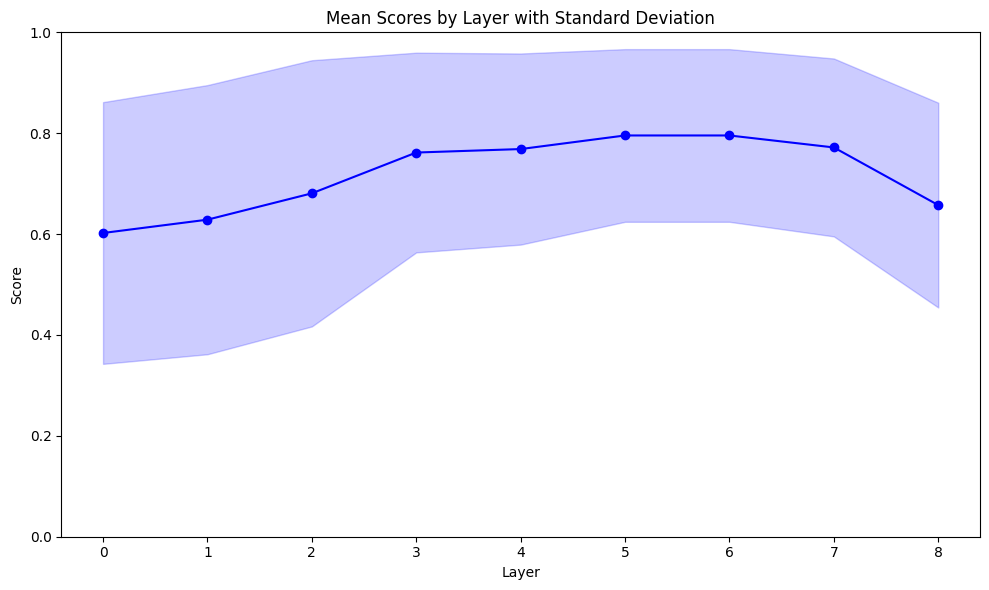

In [11]:
# Calculating mean and standard deviation for each layer
mean_scores = []
std_scores = []

for i in range(len(layers)):
    layer_scores = [scores[concept][i] for concept in scores]
    mean_scores.append(np.mean(layer_scores))
    std_scores.append(np.std(layer_scores))

# Plotting the mean scores with standard deviation shading
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(layers, mean_scores, marker='o', color='blue', label='Mean Score')
ax.fill_between(layers, np.array(mean_scores) - np.array(std_scores), np.array(mean_scores) + np.array(std_scores), color='blue', alpha=0.2)

ax.set_xlabel('Layer')
ax.set_xticks(layers)
ax.set_ylabel('Score')
ax.set_ylim([0, 1])
ax.set_title('Mean Scores by Layer with Standard Deviation')
plt.tight_layout()
plt.savefig('../figures/concept scores/concept_scores_mean_std.png')
plt.show()